In [1]:
# Standard library imports
import os
import json
import sys
import re
import concurrent.futures
from typing import List, Dict, Any, Tuple, TypedDict, Annotated, Optional

# Third-party imports
import boto3
import fitz
import requests
from bs4 import BeautifulSoup
from opensearchpy import OpenSearch, RequestsHttpConnection
from pydantic import BaseModel, Field, ValidationError
from IPython.display import Image

# LangChain core imports
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage, AIMessage, ToolMessage, SystemMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnableParallel, RunnablePassthrough, RunnableLambda
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles
from langchain_core.tools import tool
from langchain.schema import BaseRetriever, Document

# LangGraph imports
from langgraph.graph import StateGraph, add_messages, START, END
from langgraph.prebuilt import ToolNode, tools_condition

# LangChain AWS imports
from langchain_aws import ChatBedrockConverse, BedrockEmbeddings

# LangChain experimental imports
from langchain_experimental.tools.python.tool import PythonAstREPLTool

# LangChain community imports
from langchain_community.tools.tavily_search import TavilySearchResults

# Operator imports
from operator import itemgetter



In [2]:
# https://app.tavily.com/sign-in (구글 아이디 필요)

In [3]:
def visualize(graph):
    display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
    )

In [4]:
class State(TypedDict):
    messages: Annotated[List, add_messages]
    tools: List[Dict[str, Any]]


In [5]:
bedrock_client = boto3.client(
    service_name='bedrock-runtime',
    region_name='us-east-1'  # replace with your region
)
llm = ChatBedrockConverse(
    model_id="anthropic.claude-3-sonnet-20240229-v1:0",
    client=bedrock_client,
    temperature=0.7,
    max_tokens=2000
)

In [6]:
# state를 정의한다
class State(TypedDict):
    messages: Annotated[List, add_messages]
    tools_list: List  # Store the tools

# Set up API key
os.environ["TAVILY_API_KEY"] = "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"
search_tool = TavilySearchResults()


@tool
def python_code_interpreter(code: str):
    """Call to execute python code."""
    return PythonAstREPLTool().invoke(code)

@tool
def search_func(question: str):
    """Search the web for information using Tavily search engine"""
    # Use the tool to search
    search_results = search_tool.invoke(question)
    return search_results

# 사용할 함수를 정의한다
tools = [search_func, python_code_interpreter]



# 사용할 함수를 toolnode에  추가한다
tool_node = ToolNode(tools)

# llm도 사용할 함수를 알수 있도록 추가한다
model_with_tools = llm.bind_tools(tools)




In [8]:
#llm이 함수를 알고있는지 있는지 테스트
model_with_tools.invoke("처음 5개의 소수를 출력하는 python code 를 작성해줘").tool_calls


[{'name': 'python_code_interpreter',
  'args': {'code': 'def is_prime(n):\n    if n < 2:\n        return False\n    for i in range(2, int(n**0.5) + 1):\n        if n % i == 0:\n            return False\n    return True\n\nprimes = []\nn = 2\nwhile len(primes) < 5:\n    if is_prime(n):\n        primes.append(n)\n    n += 1\n\nprint(primes)'},
  'id': 'tooluse_Z-OEl2KFT0aqi0x9t-wFog',
  'type': 'tool_call'}]

In [9]:
#ToolNode에 명령어가 들어왔을때 이것을 이해하고 함수를 작동시키는지 확인
tool_node.invoke(
    {
        "messages": [
            model_with_tools.invoke(
                "llm에 대하여 서치해줘"
            )
        ]
    }
)


{'messages': [ToolMessage(content='[{"title": "Large language model - Wikipedia", "url": "https://en.wikipedia.org/wiki/Large_language_model", "content": "A large language model (LLM) is a type of machine learning model designed for natural language processing tasks such as language generation. LLMs are language models with many parameters, and are trained with self-supervised learning on a vast amount of text.", "score": 0.9609261}, {"title": "What is an LLM (large language model)? - Cloudflare", "url": "https://www.cloudflare.com/learning/ai/what-is-large-language-model/", "content": "A large language model (LLM) is a type of artificial intelligence (AI) program that can recognize and generate text, among other tasks. LLMs are trained on huge sets of data — hence the name \\"large.\\" LLMs are built on machine learning: specifically, a type of neural network called a transformer model. [...] Log in\\nSolutionsProductsPricingResourcesPartnersWhy Cloudflare\\nSupport\\nSign up\\nWhat i

In [12]:
from langgraph.graph import StateGraph, MessagesState, START, END


# LLM 모델을 사용하여 메시지 처리 및 응답 생성, 도구 호출이 포함된 응답 반환
def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


In [13]:
#그래프 생성

workflow = StateGraph(MessagesState)

# 에이전트와 도구 노드 정의 및 워크플로우 그래프에 추가
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

In [14]:
#시작에서 -> agent로
workflow.add_edge(START, "agent")

# 에이전트 노드에서 조건부 분기 설정, 도구 노드 또는 종료 지점으로 연결
workflow.add_conditional_edges("agent", tools_condition)

#tool에서 다시 agent로
workflow.add_edge("tools", "agent")

# 에이전트 노드에서 종료 지점으로 연결
workflow.add_edge("agent", END)


In [15]:
app = workflow.compile()


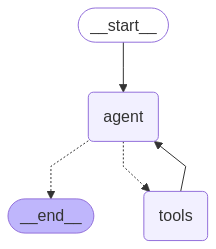

In [16]:
visualize(app)


In [17]:
for chunk in app.stream(
    {"messages": [("human", "처음 5개의 소수를 출력하는 python code 를 작성해줘")]},
    stream_mode="values",
):
    # 마지막 메시지 출력
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

처음 5개의 소수를 출력하는 python code 를 작성해줘
================================== Ai Message ==================================

[{'type': 'text', 'text': '알겠습니다. 처음 5개의 소수를 출력하는 Python 코드는 다음과 같습니다:'}, {'type': 'tool_use', 'name': 'python_code_interpreter', 'input': {'code': 'def is_prime(n):\n    if n < 2:\n        return False\n    for i in range(2, int(n**0.5) + 1):\n        if n % i == 0:\n            return False\n    return True\n\nprimes = []\nn = 2\nwhile len(primes) < 5:\n    if is_prime(n):\n        primes.append(n)\n    n += 1\n\nprint(primes)'}, 'id': 'tooluse_5zxDqs7CRMi5luqAhGmGuQ'}]
Tool Calls:
  python_code_interpreter (tooluse_5zxDqs7CRMi5luqAhGmGuQ)
 Call ID: tooluse_5zxDqs7CRMi5luqAhGmGuQ
  Args:
    code: def is_prime(n):
    if n < 2:
        return False
    for i in range(2, int(n**0.5) + 1):
        if n % i == 0:
            return False
    return True

primes = []
n = 2
while len(primes) <

In [18]:
# 검색 질문 수행
for chunk in app.stream(
    {"messages": [("human", "ai에 대해 조사해줘")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

ai에 대해 조사해줘
================================== Ai Message ==================================

[{'type': 'text', 'text': '알겠습니다. AI(인공지능)에 대한 정보를 찾아보겠습니다.'}, {'type': 'tool_use', 'name': 'search_func', 'input': {'question': 'AI 인공지능 정보'}, 'id': 'tooluse_GR03BFb7TtOC69pK6-be8Q'}]
Tool Calls:
  search_func (tooluse_GR03BFb7TtOC69pK6-be8Q)
 Call ID: tooluse_GR03BFb7TtOC69pK6-be8Q
  Args:
    question: AI 인공지능 정보
================================= Tool Message =================================
Name: search_func

[{"title": "인공지능 - 나무위키:대문", "url": "https://namu.wiki/w/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5", "content": "人工智能 / Artificial Intelligence(A.I) 인공지능은 인간의 지능[1]이 가지는 학습, 추리, 적응, 논증 따위의 기능을 갖춘 컴퓨터 시스템을 의미한다.", "score": 0.78944516}, {"title": "인공지능 - 위키백과, 우리 모두의 백과사전", "url": "https://ko.wikipedia.org/wiki/%EC%9D%B8%EA%B3%B5%EC%A7%80%EB%8A%A5", "content": "목차\n\n인공지능\n\n시리즈\n인공지능\n\n주요 목표지식 추론계획기계 학습자연어 처

In [19]:

# 도구 호출이 필요 없는 질문 수행
for chunk in app.stream(
    {"messages": [("human", "안녕? 반가워")]},
    stream_mode="values",
):
    chunk["messages"][-1].pretty_print()


================================ Human Message =================================

안녕? 반가워
================================== Ai Message ==================================

안녕하세요! 저도 반갑습니다. 오늘 하루 잘 보내셨나요? 무엇을 도와드릴까요?
